In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

helper functions

In [5]:
def calculate_iou(boxA, boxB):
    """
    Calculates Intersection over Union (IoU) for two bounding boxes.
    Assumes boxes are in [x_center, y_center, width, height] format.
    """
    if any(np.isnan(boxA)) or any(np.isnan(boxB)):
        return 0.0

    # Convert to (x1, y1, x2, y2) format
    boxA_x1 = boxA[0] - boxA[2] / 2
    boxA_y1 = boxA[1] - boxA[3] / 2
    boxA_x2 = boxA[0] + boxA[2] / 2
    boxA_y2 = boxA[1] + boxA[3] / 2
    
    boxB_x1 = boxB[0] - boxB[2] / 2
    boxB_y1 = boxB[1] - boxB[3] / 2
    boxB_x2 = boxB[0] + boxB[2] / 2
    boxB_y2 = boxB[1] + boxB[3] / 2

    # Determine the coordinates of the intersection rectangle
    xA = max(boxA_x1, boxB_x1)
    yA = max(boxA_y1, boxB_y1)
    xB = min(boxA_x2, boxB_x2)
    yB = min(boxA_y2, boxB_y2)

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (boxA_x2 - boxA_x1) * (boxA_y2 - boxA_y1)
    boxBArea = (boxB_x2 - boxB_x1) * (boxB_y2 - boxB_y1)

    # Compute the union area
    unionArea = boxAArea + boxBArea - interArea

    # Compute the IoU
    iou = interArea / unionArea if unionArea > 0 else 0
    return iou

def calculate_cle(boxA, boxB):
    """
    Calculates Center Location Error (CLE) between two bounding boxes.
    Assumes boxes are in [x_center, y_center, width, height] format.
    """
    if any(np.isnan(boxA)) or any(np.isnan(boxB)):
        return np.inf # Return infinity if a box is missing

    centerA = np.array([boxA[0], boxA[1]])
    centerB = np.array([boxB[0], boxB[1]])
    
    # Calculate Euclidean distance
    dist = np.linalg.norm(centerA - centerB)
    return dist

print("Helper functions defined.")

Helper functions defined.


Load and prepare data

load ground truth

In [6]:
# --- Configuration ---
# Point this to the correct Label.csv for your test clip
gt_csv_path = Path('../trackers/tracknet/data/tracknet_dataset/game1/Clip1/Label.csv') 
GT_BOX_WIDTH = 20  # Use the same size as your best YOLO model's training data
GT_BOX_HEIGHT = 20

# --- Load and Process ---
gt_df = pd.read_csv(gt_csv_path)

# Create a clean 'frame_id' from the filename
# e.g., '0001.jpg' -> 'frame_0001'
gt_df['frame_id'] = gt_df['file name'].apply(lambda x: f"frame_{Path(x).stem}")

# Rename columns to match our standard format
gt_df.rename(columns={
    'x-coordinate': 'gt_x',
    'y-coordinate': 'gt_y'
}, inplace=True)

# Add the fixed width and height for the bounding box
gt_df['gt_w'] = GT_BOX_WIDTH
gt_df['gt_h'] = GT_BOX_HEIGHT

# Filter out frames where the ball is not visible (visibility == 0)
gt_df = gt_df[gt_df['visibility'] != 0].copy()

# Select only the columns we need for the final DataFrame
gt_df = gt_df[['frame_id', 'gt_x', 'gt_y', 'gt_w', 'gt_h']]

print("Ground Truth data loaded and processed successfully.")
print(f"Total frames with ground truth: {len(gt_df)}")
print(gt_df.head())

Ground Truth data loaded and processed successfully.
Total frames with ground truth: 203
     frame_id   gt_x   gt_y  gt_w  gt_h
0  frame_0000  599.0  423.0    20    20
1  frame_0001  601.0  406.0    20    20
2  frame_0002  601.0  388.0    20    20
3  frame_0003  598.0  371.0    20    20
4  frame_0004  598.0  353.0    20    20


load yolo predicitons

In [7]:
from ultralytics import YOLO

# --- Run Inference to get Results ---
# (You can skip this if you have already saved the results)
model = YOLO('../trackers/yolo/runs/detect/yolov8m_tennis_ballv2_150epochs/weights/best.pt') # Use your champion yolov8m model
video_path = 'Clip1.mp4'   
yolo_results = model.track(source=video_path, persist=True, verbose=False)

# --- Process Results ---
yolo_predictions = []
for frame_idx, r in enumerate(yolo_results):
    frame_id = f"frame_{frame_idx:04d}"
    
    if r.boxes and len(r.boxes) > 0:
        # Strategy: Assume the detection with the highest confidence is the ball
        best_box_idx = r.boxes.conf.argmax()
        box = r.boxes.xywh[best_box_idx] # Get box in (x_center, y_center, w, h) format
        
        yolo_predictions.append({
            'frame_id': frame_id,
            'yolo_x': box[0].item(),
            'yolo_y': box[1].item(),
            'yolo_w': box[2].item(),
            'yolo_h': box[3].item()
        })
    else:
        # If no ball is detected, record it as a missed frame (NaN)
        yolo_predictions.append({
            'frame_id': frame_id,
            'yolo_x': np.nan, 'yolo_y': np.nan, 'yolo_w': np.nan, 'yolo_h': np.nan
        })

# Convert the list of predictions into a DataFrame
yolo_df = pd.DataFrame(yolo_predictions)

print("\nYOLOv8 tracker data loaded and processed successfully.")
print(f"Total frames processed by YOLO: {len(yolo_df)}")
print(yolo_df.head())

WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs


YOLOv8 tracker data loaded and processed successfully.
Total frames processed by YOLO: 207
     frame_id      yolo_x      yolo_y     yolo_w     yolo_h
0  frame_0000         NaN         NaN        NaN        NaN
1  frame_0001  601.288086  406.662109  19.705078  19.383545
2  frame_0002         NaN         NaN        NaN        NaN
3  frame_0003         NaN         NaN        NaN        NaN
4  frame_0004  597.472412  354.838287  19.865723  20.414429


get tracknet predicitons

In [8]:
# --- Configuration ---
# Point this to the CSV file you saved from your TrackNet inference script
tracknet_csv_path = '../trackers/tracknet/clip1_tracknet_predictions.csv' 

# --- Load and Process ---
tracknet_df = pd.read_csv(tracknet_csv_path)

# Create a clean 'frame_id'
tracknet_df['frame_id'] = tracknet_df['frame_id'].apply(lambda x: f"frame_{x:04d}")

# Select only the columns we need
tracknet_df = tracknet_df[['frame_id', 'tracknet_x', 'tracknet_y', 'tracknet_w', 'tracknet_h']]

print("\nTrackNet tracker data loaded and processed successfully.")
print(f"Total frames processed by TrackNet: {len(tracknet_df)}")
print(tracknet_df.head())


TrackNet tracker data loaded and processed successfully.
Total frames processed by TrackNet: 205
     frame_id  tracknet_x  tracknet_y  tracknet_w  tracknet_h
0  frame_0002       594.0       384.0        20.0        20.0
1  frame_0003       594.0       364.0        20.0        20.0
2  frame_0004       592.0       348.0        20.0        20.0
3  frame_0005       590.0       332.0        20.0        20.0
4  frame_0006       590.0       316.0        20.0        20.0


combine to a master df

In [9]:
# Start with the ground truth as the base
master_df = gt_df.copy()

# Merge the other results, using 'left' to keep all ground truth frames
master_df = pd.merge(master_df, tracknet_df, on='frame_id', how='left')
master_df = pd.merge(master_df, yolo_df, on='frame_id', how='left')

print("\nMaster DataFrame created successfully.")
print(master_df.head())


Master DataFrame created successfully.
     frame_id   gt_x   gt_y  gt_w  gt_h  tracknet_x  tracknet_y  tracknet_w  \
0  frame_0000  599.0  423.0    20    20         NaN         NaN         NaN   
1  frame_0001  601.0  406.0    20    20         NaN         NaN         NaN   
2  frame_0002  601.0  388.0    20    20       594.0       384.0        20.0   
3  frame_0003  598.0  371.0    20    20       594.0       364.0        20.0   
4  frame_0004  598.0  353.0    20    20       592.0       348.0        20.0   

   tracknet_h      yolo_x      yolo_y     yolo_w     yolo_h  
0         NaN         NaN         NaN        NaN        NaN  
1         NaN  601.288086  406.662109  19.705078  19.383545  
2        20.0         NaN         NaN        NaN        NaN  
3        20.0         NaN         NaN        NaN        NaN  
4        20.0  597.472412  354.838287  19.865723  20.414429  


calculate per frame metrics

In [10]:
# Create columns for the bounding boxes in list format for easy application
master_df['gt_box'] = master_df[['gt_x', 'gt_y', 'gt_w', 'gt_h']].values.tolist()
master_df['tracknet_box'] = master_df[['tracknet_x', 'tracknet_y', 'tracknet_w', 'tracknet_h']].values.tolist()
master_df['yolo_box'] = master_df[['yolo_x', 'yolo_y', 'yolo_w', 'yolo_h']].values.tolist()

# Calculate IoU and CLE for each model for every frame
master_df['tracknet_iou'] = master_df.apply(lambda row: calculate_iou(row['gt_box'], row['tracknet_box']), axis=1)
master_df['yolo_iou'] = master_df.apply(lambda row: calculate_iou(row['gt_box'], row['yolo_box']), axis=1)

master_df['tracknet_cle'] = master_df.apply(lambda row: calculate_cle(row['gt_box'], row['tracknet_box']), axis=1)
master_df['yolo_cle'] = master_df.apply(lambda row: calculate_cle(row['gt_box'], row['yolo_box']), axis=1)

print("Per-frame metrics calculated. Final DataFrame:")
print(master_df[['frame_id', 'tracknet_iou', 'yolo_iou', 'tracknet_cle', 'yolo_cle']].head())

Per-frame metrics calculated. Final DataFrame:
     frame_id  tracknet_iou  yolo_iou  tracknet_cle  yolo_cle
0  frame_0000      0.000000  0.000000           inf       inf
1  frame_0001      0.000000  0.908838           inf  0.722068
2  frame_0002      0.351351  0.000000      8.062258       inf
3  frame_0003      0.351351  0.000000      8.062258       inf
4  frame_0004      0.355932  0.793719      7.810250  1.912498


generate success plots (based on IOU)

TrackNet Success Rate (AUC): 0.295
YOLO Success Rate (AUC):     0.542


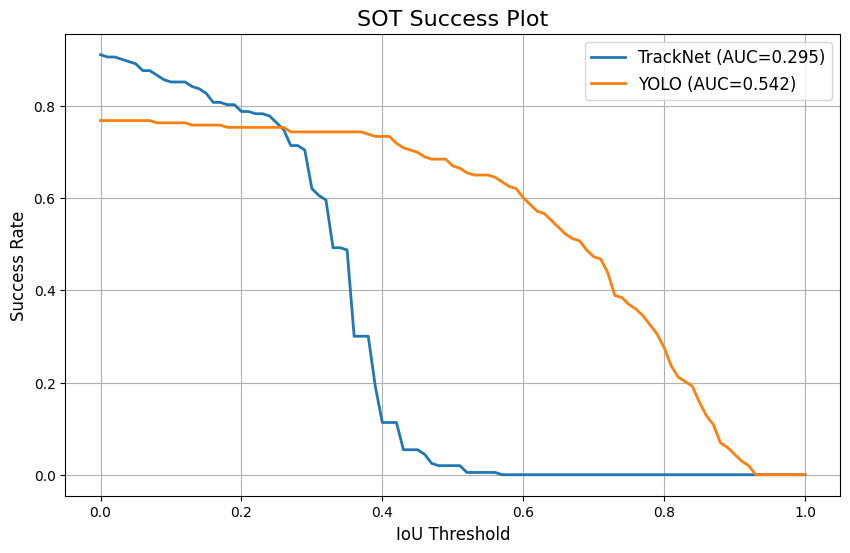

In [13]:
# --- Generate Success Plot (IoU) ---
thresholds_iou = np.linspace(0, 1, 101)
yolo_success_rates = [np.mean(master_df['yolo_iou'] > t) for t in thresholds_iou]
tracknet_success_rates = [np.mean(master_df['tracknet_iou'] > t) for t in thresholds_iou]

# Calculate Area Under the Curve (AUC)
yolo_auc = np.mean(yolo_success_rates)
tracknet_auc = np.mean(tracknet_success_rates)

print(f"TrackNet Success Rate (AUC): {tracknet_auc:.3f}")
print(f"YOLO Success Rate (AUC):     {yolo_auc:.3f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds_iou, tracknet_success_rates, label=f'TrackNet (AUC={tracknet_auc:.3f})', linewidth=2)
plt.plot(thresholds_iou, yolo_success_rates, label=f'YOLO (AUC={yolo_auc:.3f})', linewidth=2)
plt.title('SOT Success Plot', fontsize=16)
plt.xlabel('IoU Threshold', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

generate precision plot (based on CLE)

TrackNet Precision @ 20 pixels: 0.897
YOLO Precision @ 20 pixels:     0.768


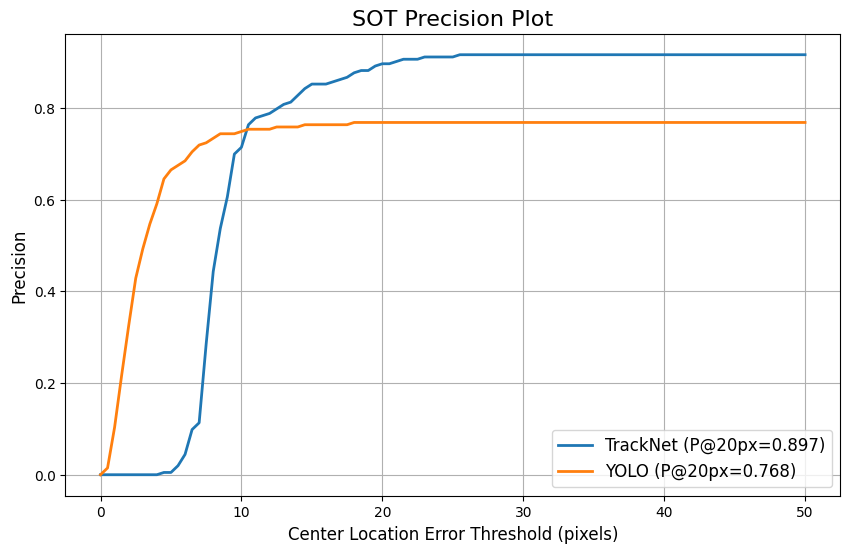

In [16]:
# --- Generate Precision Plot (CLE) ---
thresholds_cle = np.linspace(0, 50, 101) # Check error up to 50 pixels
yolo_precision_scores = [np.mean(master_df['yolo_cle'] < t) for t in thresholds_cle]
tracknet_precision_scores = [np.mean(master_df['tracknet_cle'] < t) for t in thresholds_cle]

# Get a representative score, e.g., precision at a 20 pixel threshold
# The 40th element corresponds to the threshold of 20 pixels
tracknet_p_at_20 = tracknet_precision_scores[40]
yolo_p_at_20 = yolo_precision_scores[40]

print(f"TrackNet Precision @ 20 pixels: {tracknet_p_at_20:.3f}")
print(f"YOLO Precision @ 20 pixels:     {yolo_p_at_20:.3f}")


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds_cle, tracknet_precision_scores, label=f'TrackNet (P@20px={tracknet_p_at_20:.3f})', linewidth=2)
plt.plot(thresholds_cle, yolo_precision_scores, label=f'YOLO (P@20px={yolo_p_at_20:.3f})', linewidth=2)
plt.title('SOT Precision Plot', fontsize=16)
plt.xlabel('Center Location Error Threshold (pixels)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()